In [1]:
# Using newly preprocessed subjects

import pickle

metadictname = '/home/anton/Documents/Tulane/Research/PNC_Good/PNC_agesexwrat.pkl'
alltsname = '/home/anton/Documents/Tulane/Research/PNC_Good/PNC_PowerTS_float2.pkl'

with open(metadictname, 'rb') as f:
    metadict = pickle.load(f)

with open(alltsname, 'rb') as f:
    allts = pickle.load(f)
    
print(list(metadict.keys()))
print(list(allts.keys()))
print('Complete')

['age', 'sex', 'wrat', 'missingage', 'missingsex', 'missingwrat', 'failedqc']
['emoid', 'nback', 'rest']
Complete


In [2]:
'''
Get subjects that have all tasks and paras specified
Functions for creating independent and response variables
'''

import numpy as np

def get_subs(allts, metadict, tasks, paras):
    # Get subs for all paras
    for i,para in enumerate(paras):
        tmpset = set([int(sub[4:]) for sub in allts[para].keys()])
        if i == 0:
            paraset = tmpset
        else:
            paraset = paraset.intersection(tmpset)
    # Get subs for all tasks
    for i,task in enumerate(tasks):
        tmpset = set([sub for sub in metadict[task].keys()])
        if i == 0:
            taskset = tmpset
        else:
            taskset = paraset.intersection(tmpset)
    # Remove QC failures
    allsubs = taskset.intersection(paraset)
    for badsub in metadict['failedqc']:
        try:
            allsubs.remove(int(badsub[4:]))
        except:
            pass
    return allsubs

def get_X(allts, paras, subs):
    X = []
    for para in paras:
        pX = [allts[para][f'sub-{sub}'] for sub in subs]
        pX = np.stack(pX)
        X.append(pX)
    return X

def get_y(metadict, tasks, subs):
    y = []
    for task in tasks:
        if task == 'age' or task == 'wrat':
            var = [metadict[task][sub] for sub in subs]
            var = np.array(var)
            y.append(var)
        if task == 'sex':
            maleness = [metadict[task][sub] == 'M' for sub in subs]
            maleness = np.array(maleness)
            sex = np.stack([maleness, 1-maleness], axis=1)
            y.append(sex)
    return y

subs = get_subs(allts, metadict, ['age'], ['rest', 'nback', 'emoid'])
print(len(subs))

X = get_X(allts, ['rest'], subs)
print(X[0].shape)

847
(847, 264, 124)


In [3]:
# TS to condensed FC

from scipy import signal

def butter_bandpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = [cutoff[0] / nyq, cutoff[1] / nyq]
    b, a = signal.butter(order, normal_cutoff, btype='band', analog=False)
    return b, a

def butter_bandpass_filter(data, cutoff, fs, order=5):
    b, a = butter_bandpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

tr = 1.83
N = X[0].shape[0]

def filter_design_ts(X):
    Xs = []
    for i in range(X.shape[0]):
        nX = butter_bandpass_filter(X[i], [tr/20*N, 0.8*N], 2*N)
        Xs.append(nX)
    return np.stack(Xs)

def ts_to_flat_fc(X):
    p = np.corrcoef(X)
    a,b = np.triu_indices(p[0].shape[0], 1)
    p = p[a,b]
    return p

ts = [ts for ts in filter_design_ts(X[0])]
ts = np.stack(ts)
print(ts.shape)

(847, 264, 124)


In [159]:
import torch 
import torch.nn as nn

mseLoss = nn.MSELoss()

alpha = 1e4
beta = 1e4

linec = [] 

for sub in range(ts.shape[0]):
    in1 = ts[sub,:,:-6].T
    in2 = ts[sub,:,1:-5].T
    in3 = ts[sub,:,2:-4].T
    in4 = ts[sub,:,3:-3].T
    in5 = ts[sub,:,4:-2].T
    in6 = ts[sub,:,5:-1].T
    out = ts[sub,:,6:].T

    in1t = torch.from_numpy(in1).float().cuda()
    in2t = torch.from_numpy(in2).float().cuda()
    in3t = torch.from_numpy(in3).float().cuda()
    in4t = torch.from_numpy(in4).float().cuda()
    in5t = torch.from_numpy(in5).float().cuda()
    in6t = torch.from_numpy(in6).float().cuda()
    outt = torch.from_numpy(out).float().cuda()

    for i in range(10):
        inp1 = torch.cat([in1t,in2t,in3t], dim=1)
        inp2 = torch.cat([in2t,in3t,in4t], dim=1)
        inp3 = torch.cat([in3t,in4t,in5t], dim=1)
        inps = [inp1,inp2,inp3]
        outs = [in4t,in5t,in6t]
        outhat = []
        ws = []
        for inp,outp in zip(inps,outs):
            A1 = (inp.T@inp + alpha*torch.eye(inp.shape[-1]).float().cuda())
            B1 = (inp.T@outp)
            if i > 0:
                A1 = torch.cat([A1, beta*torch.eye(w2.shape[0]).float().cuda()], dim=0)
                B1 = torch.cat([B1, beta*w2], dim=0)
            w1,_,_,_ = torch.linalg.lstsq(A1, B1)
            ws.append(w1)
            outhatsingle = inp@w1
            outhat.append(outhatsingle)
        inp4 = torch.cat(outhat, dim=1)
        A2 = (inp4.T@inp4 + alpha*torch.eye(inp4.shape[-1]).float().cuda())
        B2 = (inp4.T@outt)
        A2 = torch.cat([A2, beta*torch.eye(w1.shape[0]).float().cuda()], dim=0)
        B2 = torch.cat([B2, beta*sum(ws)/3], dim=0)
        w2,_,_,_ = torch.linalg.lstsq(A2, B2)
        outhatsingle = inp4@w2
        ws.append(w2)
    linec.append(sum(ws)/4)
    if sub % 20 == 0:
        print(f'Finished {sub}')
        print(mseLoss(outhatsingle, outt)**0.5)
        print(torch.std(in5t))
        
linec = torch.stack(linec)
print('Complete')
print(linec.shape)

Finished 0
tensor(2.7916, device='cuda:0')
tensor(3.3885, device='cuda:0')
Finished 20
tensor(2.6195, device='cuda:0')
tensor(3.2208, device='cuda:0')
Finished 40
tensor(4.0843, device='cuda:0')
tensor(8.4761, device='cuda:0')
Finished 60
tensor(3.0980, device='cuda:0')
tensor(5.4732, device='cuda:0')
Finished 80
tensor(2.9814, device='cuda:0')
tensor(4.7229, device='cuda:0')
Finished 100
tensor(3.8566, device='cuda:0')
tensor(5.8180, device='cuda:0')
Finished 120
tensor(3.6770, device='cuda:0')
tensor(6.3754, device='cuda:0')
Finished 140
tensor(6.0420, device='cuda:0')
tensor(16.7355, device='cuda:0')
Finished 160
tensor(4.1133, device='cuda:0')
tensor(9.0148, device='cuda:0')
Finished 180
tensor(3.0288, device='cuda:0')
tensor(4.9783, device='cuda:0')
Finished 200
tensor(3.8881, device='cuda:0')
tensor(33.8152, device='cuda:0')
Finished 220
tensor(3.1737, device='cuda:0')
tensor(4.3068, device='cuda:0')
Finished 240
tensor(3.0400, device='cuda:0')
tensor(4.2233, device='cuda:0')
Fin

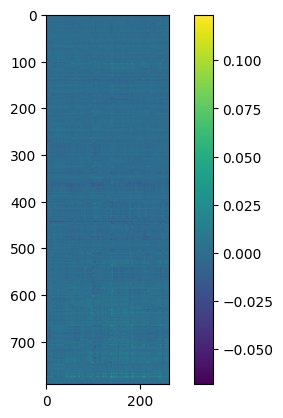

In [141]:
import matplotlib.pyplot as plt

plt.imshow(w1.detach().cpu().numpy())
# plt.imshow(torch.std(torch.stack([w1,w2]),dim=0).detach().cpu().numpy())
plt.colorbar()
plt.show()

/tmp/ipykernel_86221/3046237438.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


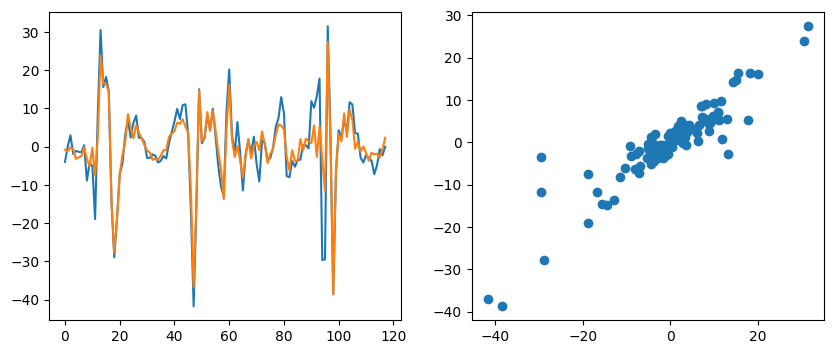

In [160]:
def getroi(ts, roi):
    return ts[:,roi].detach().cpu().numpy()

roi = 200
yhat = getroi(outhatsingle, roi)
y = getroi(outt, roi)

fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(y)
ax[0].plot(yhat)
ax[1].scatter(y, yhat)
fig.show()

In [161]:
import torch
import torch.nn as nn
import torch.nn.functional as F

xec = linec.reshape(linec.shape[0],-1)

mu = torch.mean(xec, dim=1, keepdims=True)
sigma = torch.std(xec, dim=1, keepdims=True)

# xec = (xec-mu)/sigma

xectr = xec[:600]
xect = xec[600:]

y = get_y(metadict, ['age'], subs)[0]
y_t = torch.from_numpy(y).float().cuda()
ytr = y_t[:600]
yt = y_t[600:]

print(xec.shape)
print(xectr.shape)
print(xect.shape)
print(y.shape)

torch.Size([847, 209088])
torch.Size([600, 209088])
torch.Size([247, 209088])
(847,)


In [162]:
mseLoss = nn.MSELoss()

w, _, _, _ = torch.linalg.lstsq(xectr, ytr)
yhattr = xectr@w
yhatt = xect@w
print(mseLoss(yhattr, ytr)**0.5)
print(mseLoss(yhatt, yt)**0.5)

tensor(4.2297e-05, device='cuda:0')
tensor(44.7128, device='cuda:0')


In [163]:
class MLP(nn.Module):
    def __init__(self, dim):
        super(MLP, self).__init__()
        self.l0 = nn.Linear(dim,20).float().cuda()
        self.l1 = nn.Linear(20,1).float().cuda()
        
    def forward(self, x):
        y = F.relu(self.l0(x))
        y = self.l1(y).squeeze()
        return y

mseLoss = nn.MSELoss()
    
mlp = MLP(xec.shape[1])
optim = torch.optim.Adam(mlp.parameters(), lr=1e-3, weight_decay=1e-1)

nEpochs = 10000
pPeriod = 1000

sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=10, factor=0.95, eps=1e-7)

for epoch in range(nEpochs):
    optim.zero_grad()
    yhat = mlp(xectr)
    loss = mseLoss(yhat, ytr)
    l1loss = 1e-1*(torch.sum(torch.abs(mlp.l0.weight))+torch.sum(torch.abs(mlp.l0.bias)))
    (loss+l1loss).backward()
    optim.step()
    sched.step(loss)
    if epoch % pPeriod == 0 or epoch == nEpochs-1:
        print(f'{epoch} {float(loss)**0.5} {float(l1loss)**0.5} lr: {sched._last_lr}')
        
print('Complete')
print(mseLoss(mlp(xect), yt)**0.5)

0 184.70964334259867 21.379010811342145 lr: [0.001]
1000 41.02954525685576 46.99885979750599 lr: [0.001]
2000 28.995454629306234 31.96793189171914 lr: [0.001]
3000 22.73940692809305 26.76009000343959 lr: [0.001]
4000 19.136014272473986 24.084927656822533 lr: [0.001]
5000 16.54060407760107 22.1467936449049 lr: [0.001]
6000 14.495334269211313 20.595891213134752 lr: [0.001]
7000 12.815078103805712 19.302074988895704 lr: [0.001]
8000 11.436039065251268 18.34808329620648 lr: [0.001]
9000 10.322076962857254 17.75462947165559 lr: [0.001]
9999 9.41491016671246 17.35682485065988 lr: [0.001]
Complete
tensor(31.2276, device='cuda:0', grad_fn=<PowBackward0>)


In [13]:
import sys 

sys.path.append('../../LatentSimilarity')

from latsim import LatSim

print('Complete')

Complete


In [168]:
sim = LatSim(1, xec.unsqueeze(1), dp=0.5, edp=0, wInit=1e-4, dim=10, temp=10)
optim = torch.optim.Adam(sim.parameters(), lr=1e-3, weight_decay=1e-3)

nEpochs = 1000
pPeriod = 100

sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=10, factor=0.95, eps=1e-7)

for epoch in range(nEpochs):
    optim.zero_grad()
    yhat = sim(xectr.unsqueeze(1), [ytr])[0][0]
    loss = mseLoss(yhat, ytr)
    loss.backward()
    optim.step()
    sched.step(loss)
    if epoch % pPeriod == 0 or epoch == nEpochs-1:
        print(f'{epoch} {float(loss)**0.5} lr: {sched._last_lr}')
        
print('Complete')

print(mseLoss(sim(xec.unsqueeze(1), [y_t], torch.arange(600,y_t.shape[0]))[0][0][600:], yt)**0.5)

0 40.08103821039866 lr: [0.0001]
100 27.74906521159204 lr: [0.0001]
200 17.124837832831624 lr: [0.0001]
300 10.596323606544365 lr: [0.0001]
400 8.294258466598578 lr: [0.0001]
500 7.003083775955195 lr: [7.737809374999998e-05]
600 6.800365314768512 lr: [5.987369392383786e-05]
700 6.2330351419913255 lr: [5.133420832795048e-05]
800 5.90019246450182 lr: [3.405616262881148e-05]
900 5.9197246905052054 lr: [2.1463876394293726e-05]
999 5.86874056196825 lr: [1.4239574134637466e-05]
Complete
tensor(32.8494, device='cuda:0', grad_fn=<PowBackward0>)
